In [15]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns


In [16]:
data = pd.read_csv('orders.csv')
data.head()

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item
0,2714054,469662,21386,2015-10-15 08:50:56.000,597982.0,محمود آباد,1.0
1,11104039,3063877,248497,2018-02-11 00:29:26.000,980000.0,خرمدره,1.0
2,4228130,3184893,50144,2016-06-14 00:30:08.000,229358.0,قرچک,1.0
3,22225624,6888562,70208,2018-09-03 14:37:19.000,16514.0,قم,1.0
4,4068771,2533490,67627,2016-05-21 11:51:02.000,133028.0,تهران,1.0


In [17]:
data['DayTime_CartFinalize'] = pd.to_datetime(data['DateTime_CartFinalize'], format='%Y-%m-%d')


In [18]:
data = data.loc[(data['DayTime_CartFinalize'] > '2014-12-30')
                     & (data['DayTime_CartFinalize'] < '2015-12-30')]


In [19]:
data.head()

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item,DayTime_CartFinalize
0,2714054,469662,21386,2015-10-15 08:50:56.000,597982.0,محمود آباد,1.0,2015-10-15 08:50:56
19,2589206,1351072,36298,2015-09-20 09:25:01.000,523761.0,تهران,1.0,2015-09-20 09:25:01
26,1847113,1477206,10792,2015-03-09 17:26:57.000,1657407.0,تهران,1.0,2015-03-09 17:26:57
28,2592465,1417307,32475,2015-09-20 15:56:56.000,73394.0,تهران,1.0,2015-09-20 15:56:56
62,2853988,888508,93851,2015-11-13 23:05:58.000,14211009.0,کرمانشاه,1.0,2015-11-13 23:05:58


In [20]:
LastDay = max(data['DayTime_CartFinalize'])
LastDay

Timestamp('2015-12-29 23:29:48')

In [21]:
min(data['DayTime_CartFinalize'])

Timestamp('2014-12-30 01:17:49')

In [22]:
data.shape

(19215, 8)

In [23]:
data_describe = data.filter(['Amount_Gross_Order', 'Quantity_item'])

In [25]:
data_describe.describe()

,Amount_Gross_Order,Quantity_item
count,1.921500e+04,19215.000000
mean,1.704864e+06,1.189539
std,4.292106e+06,1.420121
min,9.170000e+02,1.000000
25%,1.100920e+05,1.000000
50%,3.027520e+05,1.000000
75%,1.169815e+06,1.000000
max,9.495413e+07,100.000000


In [26]:
data_describe.corr()

,Amount_Gross_Order,Quantity_item
Amount_Gross_Order,1.000000,-0.035806
Quantity_item,-0.035806,1.000000


In [27]:
Recency = data.groupby('ID_Customer')['DayTime_CartFinalize'].apply( lambda x: (LastDay - x.max()).days)
Recency = Recency.reset_index()
Recency.head()

,ID_Customer,DayTime_CartFinalize
0,466132,176
1,466152,147
2,466233,173
3,466317,12
4,466339,77


In [28]:
Frequency = data.groupby('ID_Customer')['ID_Order'].count()
Frequency = Frequency.reset_index()
Frequency.head()

,ID_Customer,ID_Order
0,466132,2
1,466152,2
2,466233,1
3,466317,1
4,466339,3


In [29]:
RFM1 = pd.merge(Recency, Frequency, on='ID_Customer', how = 'inner' )
RFM1.head()

,ID_Customer,DayTime_CartFinalize,ID_Order
0,466132,176,2
1,466152,147,2
2,466233,173,1
3,466317,12,1
4,466339,77,3


In [31]:
Monetary = data.groupby('ID_Customer')['Amount_Gross_Order'].sum()
Monetary = Monetary.reset_index()
Monetary.head()

,ID_Customer,Amount_Gross_Order
0,466132,29667696.0
1,466152,643027.0
2,466233,5770642.0
3,466317,150000.0
4,466339,857404.0


In [32]:
RFM = pd.merge(RFM1, Monetary, on='ID_Customer', how = 'inner' )
RFM.head()

,ID_Customer,DayTime_CartFinalize,ID_Order,Amount_Gross_Order
0,466132,176,2,29667696.0
1,466152,147,2,643027.0
2,466233,173,1,5770642.0
3,466317,12,1,150000.0
4,466339,77,3,857404.0


In [33]:
RFM.columns = ['ID_Customer','Recency', 'Frequency', 'Monetary']
RFM.head()

,ID_Customer,Recency,Frequency,Monetary
0,466132,176,2,29667696.0
1,466152,147,2,643027.0
2,466233,173,1,5770642.0
3,466317,12,1,150000.0
4,466339,77,3,857404.0


In [34]:
rfm_df = RFM[['Recency', 'Frequency', 'Monetary']]

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,10))
rfm_N = scaler.fit_transform(rfm_df)

In [36]:
rfm_N

array([[5.35164835, 1.52941176, 2.60180242],
       [4.63461538, 1.52941176, 1.03466953],
       [5.27747253, 1.        , 1.31152554],
       ...,
       [1.        , 1.        , 1.02422262],
       [1.        , 1.        , 1.00614237],
       [1.        , 1.        , 1.01357263]])

In [37]:
rfm_df_scaled = pd.DataFrame(rfm_N)
rfm_df_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df_scaled.head()

,Recency,Frequency,Monetary
0,5.351648,1.529412,2.601802
1,4.634615,1.529412,1.034670
2,5.277473,1.000000,1.311526
3,1.296703,1.000000,1.008049
4,2.903846,2.058824,1.046244


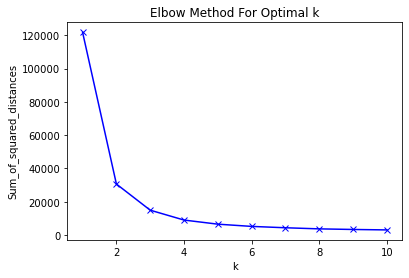

In [38]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(rfm_df_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [39]:
km = KMeans(n_clusters=6 ,init='k-means++', max_iter=300 )
km = km.fit(rfm_df_scaled)
km

KMeans(n_clusters=6)

In [40]:
km.labels_

array([2, 5, 2, ..., 3, 3, 3])

In [41]:
RFM['Cluster_Id'] = km.labels_
RFM.head()

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
0,466132,176,2,29667696.0,2
1,466152,147,2,643027.0,5
2,466233,173,1,5770642.0,2
3,466317,12,1,150000.0,3
4,466339,77,3,857404.0,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

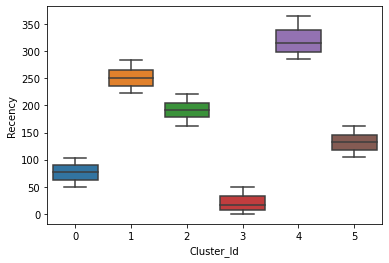

In [42]:
sns.boxplot(x='Cluster_Id', y='Recency', data=RFM)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

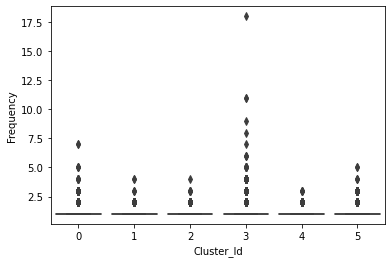

In [43]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=RFM)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

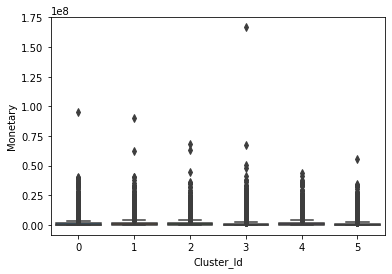

In [44]:
sns.boxplot(x='Cluster_Id', y='Monetary', data=RFM)


In [52]:
RFM.shape

(17470, 5)

In [53]:
RFM[RFM['Cluster_Id'] == 0].shape

(3356, 5)

In [54]:
RFM[RFM['Cluster_Id'] == 1].shape

(2132, 5)

In [55]:
RFM[RFM['Cluster_Id'] == 2].shape

(2260, 5)

In [56]:
RFM[RFM['Cluster_Id'] == 3].shape

(3738, 5)

In [57]:
RFM[RFM['Cluster_Id'] == 4].shape

(2951, 5)

In [58]:
RFM[RFM['Cluster_Id'] == 5].shape

(3033, 5)

In [59]:
RFM.describe()

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
count,1.747000e+04,17470.000000,17470.000000,1.747000e+04,17470.000000
mean,1.516107e+06,151.270693,1.099886,1.875155e+06,2.566400
std,9.371762e+05,105.953993,0.420896,4.664899e+06,1.738376
min,4.661320e+05,0.000000,1.000000,9.170000e+02,0.000000
25%,7.546725e+05,60.000000,1.000000,1.330280e+05,1.000000
50%,1.184968e+06,134.000000,1.000000,3.669720e+05,3.000000
75%,2.494915e+06,241.000000,1.000000,1.366972e+06,4.000000
max,3.430480e+06,364.000000,18.000000,1.666888e+08,5.000000


In [61]:
RFM.corr()

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
ID_Customer,1.000000,-0.291037,-0.100325,-0.004454,-0.111982
Recency,-0.291037,1.000000,-0.135128,0.050508,0.188680
Frequency,-0.100325,-0.135128,1.000000,0.092506,0.000362
Monetary,-0.004454,0.050508,0.092506,1.000000,-0.001118
Cluster_Id,-0.111982,0.188680,0.000362,-0.001118,1.000000


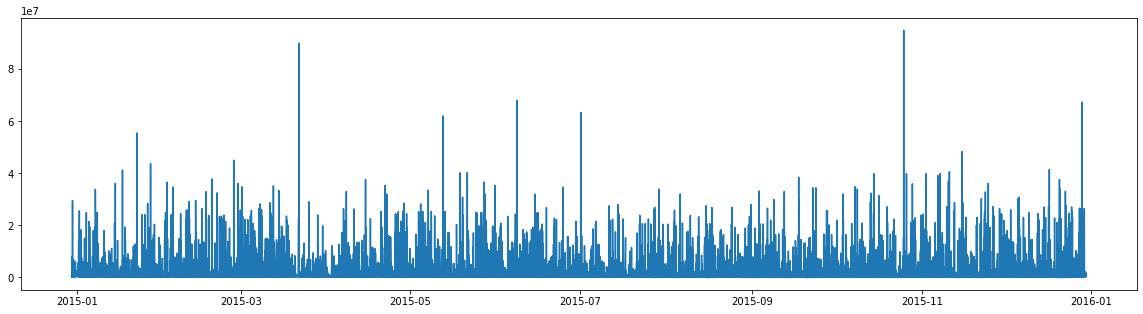

In [45]:
df_average_sales = data.groupby(by=['DayTime_CartFinalize'], as_index=False)['Amount_Gross_Order'].sum()
df_average_saless = df_average_sales.sort_values('Amount_Gross_Order', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales.DayTime_CartFinalize, df_average_sales.Amount_Gross_Order)
plt.show()

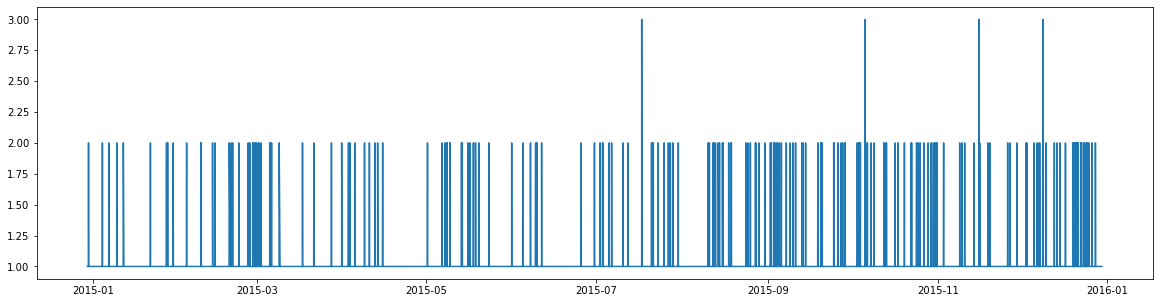

In [46]:
df_average_sales = data.groupby(by=['DayTime_CartFinalize'], as_index=False)['ID_Order'].count()
df_average_saless = df_average_sales.sort_values('ID_Order', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales.DayTime_CartFinalize, df_average_sales.ID_Order)
plt.show()

In [47]:
orders = data.filter(['city_name_fa', 'Quantity_item'])

In [48]:
groups = orders.groupby(by=['city_name_fa'], as_index=False)
groups.first()

,city_name_fa,Quantity_item
0,آب بر,1.0
1,آبادان,1.0
2,آباده,1.0
3,آبدان,1.0
4,آبدانان,1.0
...,...,...
516,گوگان,1.0
517,گیلانغرب,1.0
518,گیوی,1.0
519,یاسوج,1.0


In [49]:
orders = groups.sum()
orders.head()

,city_name_fa,Quantity_item
0,آب بر,3.0
1,آبادان,52.0
2,آباده,13.0
3,آبدان,1.0
4,آبدانان,5.0


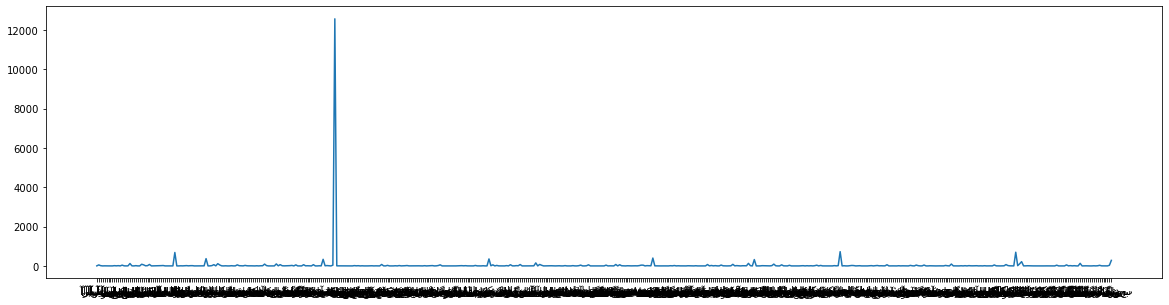

In [50]:
df_average_sales = orders.groupby(by=['city_name_fa'], as_index=False)['Quantity_item'].sum()
df_average_saless = df_average_sales.sort_values('Quantity_item', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales.city_name_fa, df_average_sales.Quantity_item)
plt.show()

In [51]:
orders[orders['Quantity_item'] == orders['Quantity_item'].max()]


,city_name_fa,Quantity_item
122,تهران,12568.0
